# Практическое задание 4 

# Мультиязычный тематический поиск

## курс "Математические методы анализа текстов"


### ФИО: <Волынцев Дмитрий Александрович>

## Введение

### Постановка задачи:

В этом задании вам предстоит сделать свою небольшую мультиязычную поисковую систему. Проще всего строить мультиязычные системы, имея "параллельные" данные: словари или корпуса параллельных текстов. 

В задании необходимо, имея англо-русскую и агло-испанскую коллекции, обучить модель поиска модель поиска испанских текстов по русским.

Решение этого задания будет основано на тематическом моделировании, а именно подходе аддитивной регуляризации.

### Библиотеки

Для этого задания вам понадобятся следующие библиотеки:
 - [bigartm](http://bigartm.org/)
 - [pymorphy2](https://pymorphy2.readthedocs.io/en/latest/)
 - [nltk](http://www.nltk.org/)


### Данные

Данные — записи выступлений конференции TED Talks на трёх языках. 

Все данные содержатся в архиве `ted_collection`. В папке содержится три подпапки `/en`, `/ru` и `/es`, каждая из которых соответствует коллекции для отдельного языка. Папка `parallel_info`  содержит информацию о связях документов между коллекциями. Файл `titles_file.json` содержит информацию о заголовках документов английской коллекции.

Ссылка для скачивания данных: [ссылка на гугл диск](https://drive.google.com/file/d/1B3kDfISvWnVpEet_CDa6oLNp028mEak-/view)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Импорт важных библиотек

In [3]:
pip install pymorphy2

     |████████████████████████████████| 61kB 5.2MB/s 
     |████████████████████████████████| 8.2MB 10.3MB/s 


In [4]:
pip install bigartm

     |████████████████████████████████| 1.9MB 7.9MB/s 


In [5]:
# считывание
import os
import glob
import json

# предобработка
import pymorphy2
import nltk
import re

# тематическое моделирование
import artm

# change log style for artm
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

# визуализация
import matplotlib.pyplot as plt
%matplotlib inline

# прочее 
import numpy as np

#### Несколько важных промежуточных функций

In [6]:
# загрузка коллекции
from lab4_utils import load_collection

# загрузка информации о параллельных документах
from lab4_utils import load_parallel_documents_info

# запись vowpal wabit файла специального формата
from lab4_utils import write_vw_lab4

# подсчёт позиции в выдаче переводов текстов
from lab4_utils import get_indexes_of_relevant_documents

## Предобработка данных (3 балла)

Перед тем как начать моделировать, необходимо предобработать данные. 

Заметим, что для английского языка некоторые этапы обработки не оказывают сильного влияния на модель (например, лемматизация). В русском языке одному слову может соответствовать огромное количество различных форм, поэтому без лемматизации невозможно получить модель с хорошим качеством.

#### Предобработка русских текстов


Считываем коллекцию:

In [7]:
RU_DATA_PATH = '/content/drive/My Drive/Colab Notebooks/ted_collection/ru'
ru_collection = load_collection(RU_DATA_PATH, verbose=True)

Total number of documents: 2731

Some document examples: 
	Это портрет Мориса Дрюона, Почетного пожизненного секретаря L'Academie francaise — Французской Акаде...
	Давайте проведем хламовый разговор.
Знаете, нас надо было научить отрекать могучую этику консервиров...
	Часто говорят, что история пишется победителями. Если это правда, что становится с угнетёнными, как ...
	Однажды зимним утром несколько лет назад я ехал на работу в Йоханнесбурге, Южная Африка, и заметил н...
	Кашмир Хилл: На прошлый день рождения мой муж подарил мне смарт-динамик Amazon Echo. Я была в неком ...

Some file names examples: 
	ru_2571
	ru_2650
	ru_2611
	ru_2676
	ru_2723


Выведите полностью несколько документов. Подумайте, какую информацию из них можно удалить на этапе предобработки, не ухудшив качество решения задачи.

In [8]:
## your code here ##
print(ru_collection['ru_0'])

Я не знаю почему, но меня постоянно поражает мысль, что два с половиной миллиарда людей в мире связаны друг с другом через Интернет, и что в любой момент времени более 30% населения мира может зайти в Интернет, чтобы учиться, творить и обмениваться информацией. И количество времени, которое каждый из нас тратит на всё это, также продолжает расти. Недавние исследования показали, что одно только молодое поколение тратит более 8-ми часов в день в Интернете. Мне как родителю 9-летней девочки это число кажется очень заниженным. (Смех)
Но так же, как Интернет открыл мир для всех и каждого из нас, он открыл и каждого из нас миру. И все чаще, цена, которую нас просят заплатить за всю эту связь — наша личная жизнь. Сегодня многим из нас очень хотелось бы верить, что Интернет — частная территория, но это не так. И каждым кликом мыши и каждым прикосновением к экрану, мы, как Гензель и Гретель, оставляем крошки нашей личной информации везде, где путешествуем в цифровом лесу. Мы оставляем наши дни 

In [9]:
print(ru_collection['ru_111'])

За последний год мы все смотрели одно и то же шоу, и я сейчас говорю не про сериал «Игра Престолов», а про ужасающую, жизненную драму, оказавшуюся слишком затягивающей, чтобы от неё отказаться. Это шоу снимается убийцами и выкладывается в интернете по всему миру. Эти имена стали знакомыми: Джеймс Фоули, Стивен Сотлофф, Дэвид Хэйнс, Алан Хеннинг, Питер Кассиг, Харуна Юкава, Кенджи Гото Його.
Их обезглавливание боевиками «Исламского государства» [ИГ] было варварским, но если нам кажется, что подобные действия слишком примитивны и что они поступают так, как поступали в далёкие смутные времена, то мы ошибаемся. Они были необыкновенно современны, потому что эти убийцы прекрасно знали, что их записи будут просмотрены миллионами людей.
СМИ называют их дикарями и варварами, потому что сцена того, как один человек может надругаться над другим, разрезая ему горло ножом, ассоциируется у нас только с древними, первобытными временами, в противоположность цивилизованному миру, который бесконечно дал

In [10]:
print(ru_collection['ru_119'])

Вот так выглядела моя прошлая неделя. Что я делала, с кем я была, Мои основные ощущения за всё время... Если ко мне приходили воспоминания об отце, который недавно умер, или если я могла избежать волнений и тревог. Если вы думаете, что я немного одержима, вы наверняка правы. Тем не менее из этой визуализации вы можете узнать обо мне гораздо больше, чем из следующей, на которой, возможно, более знакомые вам изображения. Вероятно, подобные изображения сейчас есть у вас в телефоне. Графики с количеством пройденных шагов, круговые диаграммы качества вашего сна, маршрут ваших утренних пробежек.
На моей основной работе я работаю с данными. Я управляю компанией по созданию визуализации данных. Мы разрабатываем способы доступного преподнесения информации с помощью визуальных изображений. Моя работа за эти годы научила меня, что чтобы действительно понимать данные и их истинный потенциал, иногда нам надо забыть о них, и посмотреть сквозь них. Данные — всегда всего лишь инструмент, которым мы из

###Вывод
Посмотрели 3 случайных текста, в каждом из них в конце есть одинаковая лицензия TED, которую можно удалить. Она занимает 157 символов с конца с учетом переноса.

In [11]:
print(ru_collection['ru_119'][-157:])


TED.com translations are made possible by volunteer translators. Learn more about the Open Translation Project.
© TED Conferences, LLC. All rights reserved.


In [12]:
for text in ru_collection:
    ru_collection[text] = ru_collection[text][:-157]

Помимо удаления специфичной информации, вам необходимо провести для русского языка следующие шаги предобработки :

1. Приведение документов к нижнему регистру.

2. Удаление всех символов кроме букв.
    1. Для некоторых способов выделения коллокаций (см. бонусную часть), может быть полезна информация о знаках препинания. Также она полезна при необходимости строить синтаксический разбор предложения.
    2. Вам может помочь функция sub из библиотеки re.
3. Токенизация документов.
    1. Воспользуйтесь стандартным методом .split, функцией split из библиотеки re или одним из токенайзеров библиотеки nltk.
4. Лемматизация документов.
    1. Воспользуйтесь библиотекой pymorphy2
    2. Шаги 3 и 4 можно выполнить вместе, воспользовавшись библиотекой mytem (или её обёрткой на python pymystem)
5. Удаление стоп-слов
    1. Базовый список стоп слов можно получить из модуля nltk.corpus

После выполнения всех шагов сохраните результат в словарь аналогичный ru_collection (ключи - названия файлов, значения - предобработанный документ в формате str).



In [13]:
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('russian'))
ru_collection_prep = ru_collection.copy()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize

lemmatizer = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)


In [15]:
for key, text in ru_collection_prep.items():
  #нижний регистр
  text = text.lower()
  #удаляем все символы кроме букв и цифр, сохраняя пробелы
  text = re.sub(r'[^\w\s]','', text)
  #удаляем цифры
  text = re.sub(r'[0-9]','', text)
  #токенизируем
  tokens = word_tokenize(text)
  #лемматизируем с удалением стоп-слов
  tokens_prep = []
  lem_word = ''
  for word in tokens:
    lem_word = lemmatizer.parse(word)[0].normal_form
    if lem_word not in stop_words:
      tokens_prep.append(lem_word)

  text_prep = ' '.join(tokens_prep)
  ru_collection_prep[key] = text_prep

Проанализируйте несколько предобработанных документов. Отметьте, какие неточности работы алгоритмов вы заметили, и как они могут повлиять на итоговую модель.

Неточность работы может заключаться в неучитывании слов-паразитов, появляющихся часто и при этом не несущих смысловой нагрузки. Попробуем их найти. Для этого объединим все слова в список и посчитаем самые часто встречающиеся

In [16]:
## your code here ##
all_tokens = []
for key, text in ru_collection_prep.items():
  tokens = word_tokenize(text)
  all_tokens.extend(tokens)

In [17]:
from collections import Counter

words_count = Counter(all_tokens)
words_count.most_common(10)

[('это', 86551),
 ('который', 36763),
 ('мочь', 28540),
 ('человек', 25652),
 ('всё', 22089),
 ('год', 18045),
 ('весь', 17132),
 ('наш', 16174),
 ('свой', 15741),
 ('хотеть', 11386)]

Как видим, есть несколько слов-паразитов, встречающихся очень часто и вряд ли несущих большую смысловую нагрузку: это, который, все, весь, свой

#### Предобработка английских текстов

Считываем коллекцию:

In [18]:
EN_DATA_PATH = '/content/drive/My Drive/Colab Notebooks/ted_collection/en'
en_collection = load_collection(EN_DATA_PATH, verbose=True)

Total number of documents: 2856

Some document examples: 
	As it turns out, when tens of millions of people are unemployed or underemployed, there's a fair amo...
	I'm thrilled to be here tonight to share with you something we've been working on for over two years...
	I had requested slides, kind of adamantly, up till the — pretty much, last few days, but was denied ...
	I'm a radio glaciologist. That means that I use radar to study glaciers and ice sheets. And like mos...
	My big idea is a very, very small idea that can unlock billions of big ideas that are at the moment ...

Some file names examples: 
	en_2763
	en_2775
	en_28
	en_2768
	en_2679


In [19]:
print(en_collection['en_0'])

I don't know why, but I'm continually amazed to think that two and a half billion of us around the world are connected to each other through the Internet and that at any point in time more than 30 percent of the world's population can go online to learn, to create and to share. And the amount of time each of us is spending doing all of this is also continuing to go grow. A recent study showed that the young generation alone is spending over eight hours a day online. As the parent of a nine-year-old girl, that number seems awfully low. (Laughter)
But just as the Internet has opened up the world for each and every one of us, it has also opened up each and every one of us to the world. And increasingly, the price we're being asked to pay for all of this connectedness is our privacy. Today, what many of us would love to believe is that the Internet is a private place; it's not. And with every click of the mouse and every touch of the screen, we are like Hansel and Gretel leaving breadcrumb

In [20]:
print(en_collection['en_0'][-157:])


TED.com translations are made possible by volunteer translators. Learn more about the Open Translation Project.
© TED Conferences, LLC. All rights reserved.


In [21]:
for text in en_collection:
    en_collection[text] = en_collection[text][:-157]

Проведите все этапы предобработки для английского языка (шаг 4 опционален, можно использовать WordNetLemmatizer из nltk):

In [22]:
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [26]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

en_collection_prep = en_collection.copy()

In [27]:
for key, text in en_collection_prep.items():
  #нижний регистр
  text = text.lower()
  #удаляем все символы кроме букв и цифр, сохраняя пробелы
  text = re.sub(r'[^\w\s]','', text)
  #удаляем цифры
  text = re.sub(r'[0-9]','', text)
  #токенизируем
  tokens = word_tokenize(text)
  #лемматизируем с удалением стоп-слов
  tokens_prep = []
  lem_word = ''
  for word in tokens:
    lem_word = lemmatizer.lemmatize(word)
    if lem_word not in stop_words:
      tokens_prep.append(lem_word)

  text_prep = ' '.join(tokens_prep)
  en_collection_prep[key] = text_prep

In [28]:
all_tokens = []
for key, text in en_collection_prep.items():
  tokens = word_tokenize(text)
  all_tokens.extend(tokens)

words_count = Counter(all_tokens)
words_count.most_common(10)

[('wa', 40574),
 ('one', 23201),
 ('people', 22364),
 ('like', 21580),
 ('thing', 16394),
 ('know', 15162),
 ('going', 14218),
 ('time', 13884),
 ('year', 13752),
 ('think', 13623)]

#### Предобработка испанских текстов 

Считываем коллекцию:

In [29]:
ES_DATA_PATH = '/content/drive/My Drive/Colab Notebooks/ted_collection/es'
es_collection = load_collection(ES_DATA_PATH, verbose=True)

Total number of documents: 2809

Some document examples: 
	Dirijo un estudio de diseño en Nueva York. Cada siete años cierro durante un año para dedicarme a al...
	Durante gran parte del siglo pasado, la arquitectura estuvo bajo el influjo de una famosa doctrina. ...
	Mi gran idea es una idea muy, muy pequeña, que puede liberar millones de grandes ideas que hoy están...
	No hay nada más grande ni más viejo que el universo. Las preguntas sobre las que me gustaría hablar ...
	Ya conocen la verdad de lo que voy a decir. Creo que la noción de que la desigualdad es divisiva y c...

Some file names examples: 
	es_2673
	es_2624
	es_2679
	es_2654
	es_2651


In [30]:
print(es_collection['es_0'])

No sé por qué, pero siempre me asombro al pensar que 2 000 millones y medio de nosotros en todo el mundo estamos interconectados a través de internet y que en cualquier momento más del 30 % de la población mundial puede estar en línea para aprender, crear y compartir. Y el tiempo que cada uno de nosotros pasa haciendo estas cosas también continúa creciendo. Un estudio reciente demostró que solamente la generación joven pasa más de 8 horas al día en línea. Como padre de una niña de 9 años, esa cifra me parece muy baja. (Risas)
Pero así como el internet ha abierto el mundo a todos nosotros, también nos muestra a todos nosotros al mundo. Y cada vez más, el precio que debemos pagar por el hecho de estar conectados es nuestra privacidad. Hoy en día, a muchos de nosotros nos gustaría creer que el internet es un lugar privado; no lo es. Y con cada clic y cada toque de la pantalla, estamos como Hansel y Gretel dejando migas de pan de nuestra información personal por todos los sitios que visita

In [31]:
print(es_collection['es_0'][-157:])


TED.com translations are made possible by volunteer translators. Learn more about the Open Translation Project.
© TED Conferences, LLC. All rights reserved.


In [32]:
for text in es_collection:
    es_collection[text] = es_collection[text][:-157]

Проведите все этапы предобработки для испанского языка (шаг 4 опционален, можно использовать SpanishStemmer из nltk). 

**Замечание.** Регулярное выражение \w из библиотеки re позволяет выделять буквы (в том числе буквы испанского алфавита).

In [33]:
stop_words = set(stopwords.words('spanish'))
lemmatizer = nltk.stem.SnowballStemmer('spanish')

es_collection_prep = es_collection.copy()

In [34]:
for key, text in es_collection_prep.items():
  #нижний регистр
  text = text.lower()
  #удаляем все символы кроме букв и цифр, сохраняя пробелы
  text = re.sub(r'[^\w\s]','', text)
  #удаляем цифры
  text = re.sub(r'[0-9]','', text)
  #токенизируем
  tokens = word_tokenize(text)
  #лемматизируем с удалением стоп-слов
  tokens_prep = []
  lem_word = ''
  for word in tokens:
    lem_word = lemmatizer.stem(word)
    if lem_word not in stop_words:
      tokens_prep.append(lem_word)

  text_prep = ' '.join(tokens_prep)
  es_collection_prep[key] = text_prep

In [35]:
all_tokens = []
for key, text in es_collection_prep.items():
  tokens = word_tokenize(text)
  all_tokens.extend(tokens)

words_count = Counter(all_tokens)
words_count.most_common(10)

[('par', 50690),
 ('com', 42360),
 ('mas', 33784),
 ('per', 31479),
 ('hac', 31155),
 ('tod', 30513),
 ('si', 28347),
 ('pued', 24147),
 ('ten', 20076),
 ('asi', 19596)]

#### Дополнительная предобработка

Библиотека BigARTM имеет собственный формат документов для обработки, называемый батчами. Самый простой способ создать батчи из коллекции файлов - сконвертировать в батчи vowpal wabbit файл с коллекцией (https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Input-format). 

Тематические модели работают с мешком слов, поэтому в vowpal wabbit файле можно не хранить информацию о порядке слов в документе.

Чтобы обучить мультиязычную модель, мы будем использовать апарат модальностей тематической модели. Каждому языку будет соответствовать своя модальность (`@english`, `@russian` и `@spanish` в vowpal wabbit файле). 

Для экспериментов нам понадобится два файла. Один будет содержать информацию о параллельных документов, а другой нет. В втором файле каждая строчка соответствует конкретному документу. В первом файле, если у документа есть параллельный, он будет располагаться на этой же строчке в рамках другой модальности.

Весь код для сохранения файла в vowpal wabbit формате уже написан, вам только необходимо правильно воспользоваться функцией. В частности, проследите, чтобы в ваших документах не содержалось символов ':', '|' и '@'.

В файлах en_ru_match.txt и en_es_match.txt содержится информация о том, какие документы являются параллельными. 

In [37]:
en_ru_parallel_docs = load_parallel_documents_info('/content/drive/My Drive/Colab Notebooks/ted_collection/parallel_info/en_ru_match.txt')
en_es_parallel_docs = load_parallel_documents_info('/content/drive/My Drive/Colab Notebooks/ted_collection/parallel_info/en_es_match.txt')

Total number of pairs: 1000
Total number of pairs: 1000


Воспользуйтесь функцией write_vw_lab4, чтобы сохранить данные в нужном формате:

In [38]:
# vowpal wabbit файлы с коллекцией
DATA_PATH_PARALLEL = '/content/drive/My Drive/Colab Notebooks/ted_collection/collection_parallel.vw'
DATA_PATH_MONO = '/content/drive/My Drive/Colab Notebooks/ted_collection/collection_mono.vw'

write_vw_lab4(
    DATA_PATH_PARALLEL,
    en_collection_prep,
    ru_collection_prep,
    es_collection_prep,
    en_ru_parallel_docs,
    en_es_parallel_docs,
    use_parallel_info=True
)


write_vw_lab4(
    DATA_PATH_MONO,
    en_collection_prep,
    ru_collection_prep,
    es_collection_prep,
    en_ru_parallel_docs,
    en_es_parallel_docs,
    use_parallel_info=False
)

## Базовая моноязычная тематическая модель (2 балла)

Теорию тематического моделирования можно узнать из соответствующей лекции курса.

Научиться пользоваться bigartm легче всего по гайду из документации [ссылка](http://docs.bigartm.org/en/stable/tutorials/python_userguide/index.html).

#### Подготовка к моделированию

Чтобы преобразовать полученный vowpal wabbit файл в батчи, можно воспользоваться стандартным классом BatchVectorizer. Объект этого класса принимает на вход адрес папки с батчами или файл vowpal wabbit, а затем подаётся на вход для обучения методам. В случае, если входные данные не являются батчами, он создаёт их и сохраняет на диск для последующего быстрого использования.

В этой части экспериментов, вам предлагается построить моноязычную тематическую модель только для английского языка, поэтому для обучения используйте файл DATA_PATH_MONO.

In [9]:
# папка с батчами
BATCHES_PATH_MONO = '/content/drive/My Drive/Colab Notebooks/ted_collection/batches_path_mono' ## your code here ##

In [10]:
# если BATCHES_PATH_MONO пуста, батчи будут созданы из файла в DATA_PATH_MONO
# иначе использовать BATCHES_PATH_MONO
if len(glob.glob(os.path.join(BATCHES_PATH_MONO + '/*.batch'))) < 1:
    batch_vectorizer_mono = artm.BatchVectorizer(data_path=DATA_PATH_MONO, 
                                                 data_format='vowpal_wabbit',
                                                 target_folder=BATCHES_PATH_MONO)
else:
    batch_vectorizer_mono = artm.BatchVectorizer(data_path=BATCHES_PATH_MONO,
                                                 data_format='batches')

Словарь – это объект BigARTM, содержащий информацию о коллекции (словарь коллекции, различные величины и счётчики, связанные со словами). Создать словарь можно на основе папки с батчами. Затем собранный словарь можно сохранять на диск и позже подгрузить вновь.

In [11]:
dictionary = artm.Dictionary()
dictionary.gather(data_path=BATCHES_PATH_MONO)

Словарь в том числе отвечает за то, на какие токены будет настраиваться модель. Редкие слова не оказывают влияние на модель, поэтому их можно удалить используя метод .filter.

In [12]:
MIN_DF = 5

dictionary.filter(min_df=MIN_DF)

artm.Dictionary(name=49864698-06c6-4f28-b7c6-5dd0a55ef4e4, num_entries=51377)

#### Обучение модели

Пришло время приступить к моделированию! Начнём с простой одноязычной модели PLSA. Будем учитывать только модальность @english в документах коллекции. Так как коллекция небольшая, используйте небольшое число тем 30-50.

Параметр theta_columns_naming='title' отвечает за именование документов лейблами из vowpal wabbit формата при получении матрицы $\Theta$ (иначе они будут нумероваться в порядке появления в коллекции).

In [16]:
model = artm.ARTM(num_topics=30,
                  num_processors=7,
                  theta_columns_naming='title',
                  show_progress_bars=True,
                  class_ids={'@english':1})

model.initialize(dictionary)

Класс artm.ARTM поддерживает различные встроенные метрики качества. Добавьте метрики измерения перплексии, разреженности $\Phi$, разреженности $\Theta$ и счётчик топ слов. Не забудьте, что метрики должны соответствовать только модальности @english!

In [17]:
## your code here ##
model.scores.add(artm.PerplexityScore(name='perplexity'))
model.scores.add(artm.SparsityPhiScore(class_id='@english', name='phi'))
model.scores.add(artm.SparsityThetaScore(name='theta'))
model.scores.add(artm.TopTokensScore(class_id='@english', num_tokens=10, name='top_tokens'))

Проведите обучение модели с помощью метода fit_offline. Подберите необходимое число операций для сходимости в зависимости от значения перплексии:

In [18]:
## your code here ##
model.fit_offline(batch_vectorizer = batch_vectorizer_mono, num_collection_passes = 5)

Pass: 100%|██████████| 5/5 [00:28<00:00,  5.69s/it]


Выведите график изменения перплексии в зависимости от итерации алгоритма, чтобы мы знали, что ваш алгоритм точно сошёлся :)

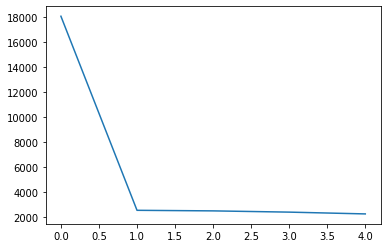

In [19]:
## your code here ##
plt.plot(model.score_tracker['perplexity'].value)

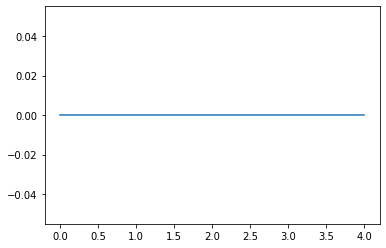

In [20]:
plt.plot(model.score_tracker['phi'].value)

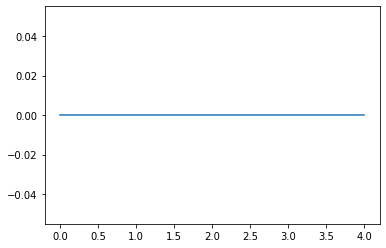

In [21]:
plt.plot(model.score_tracker['theta'].value)

Попробуем побольше

In [22]:
model.fit_offline(batch_vectorizer = batch_vectorizer_mono, num_collection_passes = 50)

Pass: 100%|██████████| 50/50 [04:39<00:00,  5.59s/it]


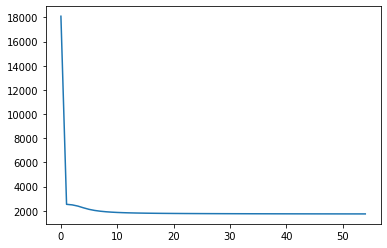

In [23]:
plt.plot(model.score_tracker['perplexity'].value)

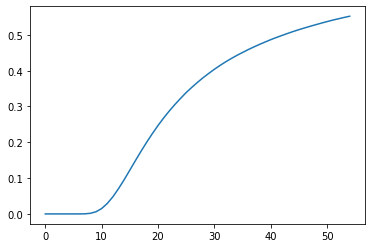

In [24]:
plt.plot(model.score_tracker['phi'].value)

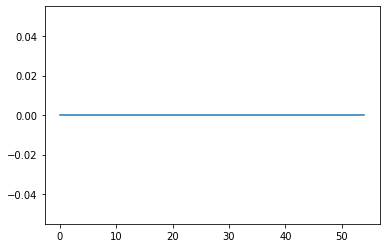

In [25]:
plt.plot(model.score_tracker['theta'].value)

#### Интерпретация результатов

Основная особенность тематических моделей — интерпретируемость получаемых матриц $\Phi$ и $\Theta$. С помощью $\Phi$ для каждой темы можно узнать топ-слова, а с помощью $\Theta$ для каждой темы можно узнать топ-документы. 
Для того, чтобы получить матрицу $\Theta$, используйте метод .transform.

Для каждой темы выведите топ её слов ($\geq 20$) и топ заголовкой её документов ($\geq 5$). Попробуйте интерпертировать полученные темы, действительно ли темы получаются осмысленными?

In [26]:
file_name_to_title = {}
with open('/content/drive/My Drive/Colab Notebooks/ted_collection/titles_file.json') as f:
    for line in f:
        file_name_to_title.update(json.loads(line))

In [28]:
## your code here ##
#получим матрицы фи и тэта
phi_matrix = model.get_phi(class_ids={'@english':1})
theta_matrix = model.transform(batch_vectorizer = batch_vectorizer_mono)

Всего у нас 30 тем. Узнаем для каждой топ-10 слов из матрицы фи

In [37]:
for i, name in enumerate(model.topic_names):
  print(name, ':\n', phi_matrix[name].sort_values(ascending=False)[:10], '\n')

topic_0 :
 country    0.032863
world      0.030014
africa     0.017658
year       0.013504
ha         0.012922
china      0.010266
india      0.009979
people     0.009963
global     0.009374
one        0.008235
Name: topic_0, dtype: float32 

topic_1 :
 health       0.019103
cancer       0.019077
patient      0.018138
doctor       0.013286
drug         0.012627
care         0.012487
medical      0.010752
disease      0.010016
hospital     0.008952
treatment    0.008451
Name: topic_1, dtype: float32 

topic_2 :
 company     0.016554
money       0.015879
business    0.014398
dollar      0.013309
percent     0.008788
market      0.008730
need        0.008142
work        0.008031
year        0.008030
make        0.007895
Name: topic_2, dtype: float32 

topic_3 :
 technology     0.021191
data           0.020497
computer       0.015148
information    0.010470
like           0.009273
new            0.008896
world          0.008535
use            0.007923
phone          0.007556
could         

Теперь выведем топ-10 документов по каждой теме из матрицы тэта

In [36]:
for i, name in enumerate(model.topic_names):
  print(name, ':\n', theta_matrix.iloc[i].sort_values(ascending=False)[:10], '\n')

topic_0 :
 en_398     0.736211
en_1967    0.716407
en_1303    0.709467
en_1832    0.648047
en_1342    0.642400
en_107     0.637532
en_1774    0.634339
en_880     0.617874
en_798     0.617842
en_177     0.604974
Name: topic_0, dtype: float32 

topic_1 :
 en_486     0.748950
en_1869    0.741900
en_860     0.662511
en_100     0.658405
en_2479    0.648534
en_2760    0.624841
en_844     0.599135
en_812     0.573151
en_1788    0.562759
en_1678    0.556575
Name: topic_1, dtype: float32 

topic_2 :
 en_956     0.742682
en_2032    0.719522
en_2062    0.659625
en_174     0.624447
en_2143    0.615299
en_849     0.604234
en_545     0.593928
en_1125    0.591997
en_949     0.574842
en_2349    0.567844
Name: topic_2, dtype: float32 

topic_3 :
 en_1987    0.555827
en_723     0.533398
en_2699    0.523871
en_738     0.515549
en_741     0.511029
en_1673    0.500078
en_2404    0.488231
en_806     0.486508
en_10      0.485460
en_1539    0.483716
Name: topic_3, dtype: float32 

topic_4 :
 en_1440    0.7741

# А здесь ваш текст про интерпретацию модели :)
По выделенным моделью топ-словам легко воссоздать тематику текста, а значит результат можно считать неплохим

## Мультиязычная тематическая модель (5 баллов)

В этом пункте задания вам будет необходимо обучить мультиязычную тематическую модель.

В данном пункте вы будете реализовывать модель ML-TD (MultiLingual Parallel).

* каждый язык — отдельная модальность
* $\theta_{td}$ — общая для всех параллельных документов

Таким образом на обучении все параллельные документы записываются в одну строку в vowpal wabbit файле.

Оценивать качество модели мы будем на задаче поиска перевода текста. Вам будет необходимо оценить качество трёх переводов: с русского на английский, с испанского на английский и с русского на испанский.

Поиск документов будет устроен следующим образом. Будем для документа d на языке A считать близости со всеми документами на языке B и ранжировать документы языка B по этой близости. Для каждого документа посчитаем позицию истинного перевода документа в выдаче. Итоговая метрика — медиана или среднее таких позиций по всем документам.

Выделим множества документов, для которых не было известно информации об их переводе:

In [39]:
ru_es_parallel_docs_test = load_parallel_documents_info('/content/drive/My Drive/Colab Notebooks/ted_collection/parallel_info/ru_es_match_test.txt', verbose=False)
ru_en_parallel_docs_test = load_parallel_documents_info('/content/drive/My Drive/Colab Notebooks/ted_collection/parallel_info/ru_en_match_test.txt', verbose=False)
es_en_parallel_docs_test = load_parallel_documents_info('/content/drive/My Drive/Colab Notebooks/ted_collection/parallel_info/es_en_match_test.txt', verbose=False)

Проведите подготовительный этап (создание батчей и словарей) для мультиязычной коллекции DATA_PATH_PARALLEL.

In [40]:
## your code here ##
BATCHES_PATH_MULTIPLE = '/content/drive/My Drive/Colab Notebooks/ted_collection/batches_path_multiple'

In [43]:
if len(glob.glob(os.path.join(BATCHES_PATH_MULTIPLE + '/*.batch'))) < 1:
    batch_vectorizer_multiple = artm.BatchVectorizer(data_path = DATA_PATH_PARALLEL, 
                                                 data_format = 'vowpal_wabbit',
                                                 target_folder = BATCHES_PATH_MULTIPLE)
else:
    batch_vectorizer_multiple = artm.BatchVectorizer(data_path = BATCHES_PATH_MULTIPLE,
                                                 data_format='batches')

In [44]:
dictionary = artm.Dictionary()
dictionary.gather(data_path = BATCHES_PATH_MULTIPLE)

In [45]:
MIN_DF = 5

dictionary.filter(min_df=MIN_DF)

artm.Dictionary(name=ff6ac7d1-95ec-400a-a106-c1a88bc62a45, num_entries=51377)

Обучите мультиязычную модель и проинтерпертируйте полученные темы. Если вы всё сделали правильно, то топ-слова различных языков для одной темы должны получиться достаточно похожими.

In [46]:
## your code here ##
model = artm.ARTM(num_topics=30,
                  num_processors=7,
                  theta_columns_naming='title',
                  show_progress_bars=True,
                  class_ids={'@english':1, '@russian': 0.5, '@spanish': 0.5})

model.initialize(dictionary)

In [47]:
model.scores.add(artm.PerplexityScore(name='perplexity'))
model.scores.add(artm.SparsityPhiScore(name='phi'))
model.scores.add(artm.SparsityThetaScore(name='theta'))
model.scores.add(artm.TopTokensScore(num_tokens=10, name='top_tokens'))

In [49]:
model.fit_offline(batch_vectorizer = batch_vectorizer_multiple, num_collection_passes = 50)

Pass: 100%|██████████| 50/50 [08:55<00:00, 10.72s/it]


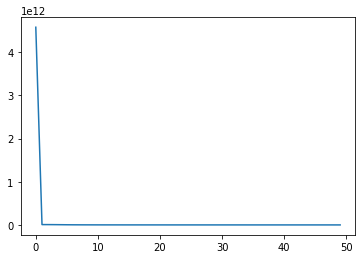

In [50]:
plt.plot(model.score_tracker['perplexity'].value)

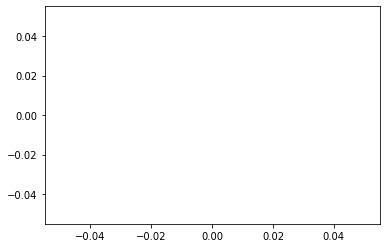

In [51]:
plt.plot(model.score_tracker['phi'].value)

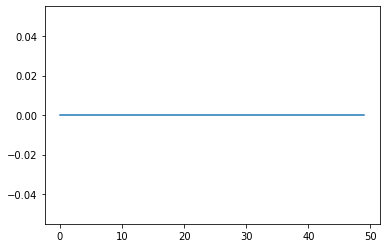

In [52]:
plt.plot(model.score_tracker['theta'].value)

Протестируйте качество на трёх задачах перевода. Добейтесь хорошего качества (медиана позиции в выдаче ~ 0, среднее ~ 10). Получить положение в выдаче переводов текстов вам поможет функция get_indexes_of_relevant_documents из модуля lab4_utils. Для того, чтобы всё работало корректно (на тесте не должна быть известна информация о параллельности документов), подавайте в качестве theta результат model.transform(batch_vectorizer_mono).

Возможные способы улучшения:
* изменять веса модальностей
* изменять количество тем, количество итераций обучения
* добавлять регуляризаторы (см. бонусную часть)
* изменять метрику для поиска ближайших документов
* добавлять шаги в предобработку (выделение колокаций)

**В первую очередь** рекомендуется подобрать количество тем (в данной задаче хорошо работает небольшое число тем - несколько десятков) и веса модальностей.

За нетривиальные подходы могут быть начислены дополнительные бонусные баллы!

In [ ]:
## your code here ##

Проведите анализ ошибок. На каких документах модель отработала лучше всего, на каких хуже всего? Как вы думаете почему?

In [ ]:
# Здесь ваш текст про ошибки модели :)

## Бонусная часть

#### Добавление фоновых тем (до 1 балла)

Основной инструмент улучшения качества тематической модели — регуляризация. Выделите часть тем модели как фоновые. Сглаживайте $\Theta$ для фоновых тем, разреживайте для предметных.

Проинтерпретируйте результаты. Фоновые темы должны иметь в качество топ-слов слова фоновой лексики! Удалось ли с помощью введения фоновых тем повысить качество модели?

#### Модальность n-грамм (до 2 баллов)

Для каждого языка добавьте дополнительную модальность n-грамм. n-граммы можно выделить, например, с помощью пакета Phrases из модуля Gensim. Как отразилось добавление новой модальности на интерпретируемости модели? Удалось ли с помощью введения n-грамм повысить качество модели?